## Simulación de medición y análisis de datos

In [40]:
#Importo librerías
import numpy as np
import matplotlib.pyplot as plt
import math

#Defino ctes
pi = math.pi

In [41]:
def S(t, t0, sigma, w):
    '''
    Señal modelo producida por el detector a tiempo t con centro t0, ancho sigma y frecuenca omega

    Paramaters
    ----------
    t (float): tiempo
    t0 (float): centro
    sigma (float): ancho
    w(float): frecuencia de oscilación

    Returns
    -------
    float: señal a tiempo t
    
    Nota:
    (1) La amplitud A de la señal se considera unitaria
    (2) El tiempo t puede ser un ndarray
    '''
    A = 10
    return A*np.exp( -(t-t0)**2/(2*sigma**2) )*np.cos(w*(t-t0+sigma))


In [42]:
#Defino tiempo inicial y tiempo final
t_ini = 0
t_fin = 8

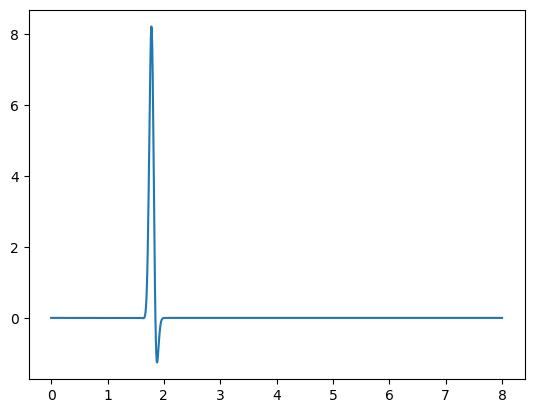

In [43]:
#Grafico S para t0 = 0.5, sigma = 0.1 y w = 0.1 y comparo con el gráfico del enunciado

M = 1000 #nro de puntos
t_array = np.linspace(t_ini,t_fin, M)
S_array = np.zeros(M)
for i in range(M):
    S_array[i] = S(t_array[i],1.8,0.05,5*pi)
plt.plot(t_array, S_array)
# plt.ylim([0,1e5])


**el ruido afecta al fondo??**  
**qué amplitud uso en S?**  
**le falta un signo (-) en la exponencial de S?**  
**es importante en betaprime que t esté en mu s??**

In [44]:
from scipy.stats import betaprime, norm

In [45]:
betaprime.rvs(a = 4, b = 2, loc = 1.8, size = 10)

array([ 6.17562173,  4.22313802,  9.47975805,  3.27502752,  6.479875  ,
        2.56437978,  3.1016863 ,  2.65953413,  5.33414011, 17.96979988])

In [60]:
#Distribuciones
def t0_dist(t0):
    '''
    Posición de cada pico determinada por la distribución Beta prime centrada en t0 con parámetros a = 4 y b = 2
    
    Parameters
    ----------
    t0 (float): centro de la distribución

    Returns
    -------
    float: posición del pico
    '''
    a = 4
    b = 2
    return betaprime.rvs(a = a, b = b, loc = t0)

def sigma_dist():
    '''
    Ancho sigma del pico central determinado por la distribución normal con valor medio sigma0 = 0.05 y desviación sigma_sigma = 0.005
    
    Parameters
    ----------
    None

    Returns
    -------
    float: ancho sigma
    '''
    sigma0 = 0.05
    sigma_sigma = 0.005
    return norm.rvs(loc = sigma0, scale = sigma_sigma)

def w_dist():
    '''
    Frecuencia de oscilación w determinada por la distribución normal con valor medio w0 = 5 pi y desviación sigma_w = 0.05
    
    Parameters
    ----------
    None

    Returns
    -------
    float: ancho sigma
    '''
    w0 = 5*pi
    sigma_w = 0.05

    return norm.rvs(loc = w0, scale = sigma_w)

def ruido_dist(señal):
    '''
    Señal de ruido a tiempo t. Está conformada por 2 componentes
    (1) Ruido relativo: dado por una distribución normal con valor medio 1 y ancho 0.1. Este se multiplica a la señal
    (2) Ruido absoluto: dado por una distribución normal con valor medio nulo y ancho 0.2. Este se suma a la señal
    
    Parameters
    ----------
    señal (float): valor simulado de la señal sin ruido ni fondo lineal

    Returns
    -------
    float: señal ruido

    Nota: puede aceptar ndarray
    '''
    ruido_rel = norm.rvs(loc = 1, scale = 0.1, size = len(señal))*señal
    ruido_abs = norm.rvs(loc = 0, scale = 0.2, size = len(señal))

    return ruido_rel + ruido_abs

def fondo(t):
    '''
    Señal de fondo lineal sobre la que se monta todo el espectro.
    
    Parameters
    ----------
    t (float): tiempo

    Returns
    -------
    float: valor del fondo a tiempo t
    '''
    
    return (-t+2)/100


### Ejercicio 1

Una medición puede estar compuesta por cualquiera de las 3 señales, cada una con una probabilidad distinta. En cada medición, la señal i con centro en t0_i tengo que tirar un dado con probabilidad P_i. En caso positivo, tengo que producir una señal S(t,t0_dist(t0), sigma_dist, w_dist)_i. Luego, le sumo el ruido y el fondo.

In [61]:
from scipy.stats import bernoulli

In [62]:
def genero_señal(T0, M):
    '''
    Produzco una señal (un pico) localizado en tiempo T0. No posee ruido ni fondo
    
    Parameters
    ----------
    T0 (float): tiempo en el que se localiza el pico
    N (int): tamaño del ndarray señal


    Returns
    -------
    señal (ndarray): array señal
    '''
    #Verifico que N sea entero TO-DO


    #Defino los parámetros característicos de la señal
    t0 = t0_dist(T0)
    sigma = sigma_dist()
    w = w_dist()

    #Creo el vector de tiempos
    t_array = np.linspace(t_ini, t_fin, M)

    #Calculo la señal
    señal = S(t_array, t0, sigma, w)

    return t_array, señal


def medicion(T0_array, P_array, M):
    '''
    Simulo una medición. Para esto es necesario producir 3 señales con centros dados por T0_array y probabilidades de ocurrencia P_array. Luego, es necesario sumar el ruido a la medición y el fondo.

    Parameters
    ----------
    T0_array (ndarray): centros de las señales posibles
    P_array (ndarray): probabilidad de ocurrencia de cada una de las señales posibles. El orden corresponde al dado en T0_array
    M (int): tamaño del ndarray medicion

    Returns
    -------
    medicion (ndarray): medicion simulada
    
    '''
    #Creo el array de mediciones y de tiempos
    medicion = np.zeros(M)

    #Para cada señal posible
    for i in range(len(T0_array)):
        #Tiro un dado con probabilidad P para ver si se observa la señal
        ocurrencia = bernoulli.rvs(P_array[i])
        print(ocurrencia)
        if ocurrencia == True: #ocurre
            t_array, señal = genero_señal(T0_array[i], M)
            medicion += señal
    
    #Sumo ruido
    medicion += ruido_dist(medicion)   

    #Sumo fondo
    medicion += fondo(t_array)

    return t_array, medicion

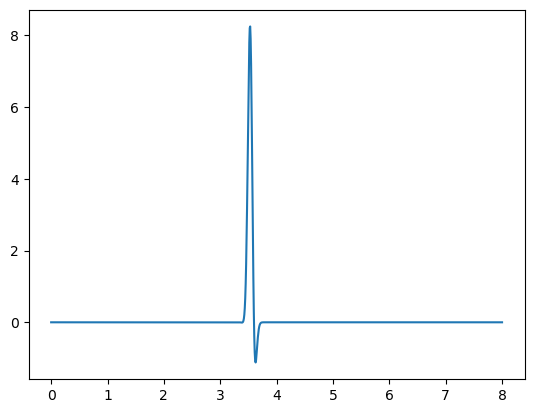

In [66]:
#Grafico una señal
T0 = 1.8
M = 1000
t_array, señal = genero_señal(T0, M)
plt.plot(t_array, señal)


In [50]:
#Grafico una medición
T0_array = np.array([1.8,2.8,5])
P_array = np.array([0.3,0.1,0.6])
t_array, medicion_array = medicion(T0_array, P_array, M)
plt.plot(t_array, medicion_array)

0
0
0


UnboundLocalError: local variable 't_array' referenced before assignment

### Ejercicio 2

In [ ]:
def mediciones(N):
    '''
    Resultado de N mediciones. Calculo N mediciones con centros de las señales y probabilidades de ocurrencia determinados.

    Parameters
    ----------
    N (int): nro de mediciones simuladas
    
    '''


    pass

def mediciones_mean(N):
    #Genero N mediciones y devuelvo el promedio
    
    

SyntaxError: incomplete input (3806987410.py, line 17)

### Ejercicio 3

### Ejercicio 4